This file contains functions to calculate Value-at-Risk measure and Expected Shortfall measure. 

In [ ]:
 !pip install yfinance

     |████████████████████████████████| 6.3MB 8.3MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=400dd098a1d3e3771a061bf9d09ac30bbe258313755fe9d2fe6e2d1b8dd46e5c
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
!pip install arch

     |████████████████████████████████| 808kB 5.1MB/s 


According to Financial Risk Forecasting  The Theory and Practice of Forecasting Market Risk, with Implementation in R and Matlab by Jón Daníelsson, Value-at-Risk is the most common risk measure after volatility. 

By def: 

Value-at-Risk - is the loss on a trading portfolio such that there is a probability p of losses equaling or exceeding VaR in a given trading period and (1- p) probability of losses being lower than the VaR. 

There are several approaches to compute VaR and ES:

1) Model simulated (e.g. ARMA-GARCH) **(optimal approach)** 

2) Historical VaR **(data driven)** 

3) Analytical VaR **(assumption driven)** 



In [ ]:
# Import necessary libraries: 

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm, t
from arch import arch_model

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Define functions to perform necessary calculations:


In [ ]:
# Define data downloader function: 

def stock_data_download(symbols, start_date, end_date):
  data_holder = dict()
  for idx in symbols:
    stock_data = yf.download(idx, start_date, end_date)
    data_holder[idx] = stock_data

  return data_holder

# Define data extractor function:

def stock_data_extract(symbols, col_name, data):
  data_holder = pd.DataFrame()
  for idx in symbols:
    data_point = data[idx][col_name]
    data_holder[idx] = data_point
  
  return data_holder

# Define stock data stat function: 

def stock_portfolio_returns(data, weights):
  returns = data.pct_change()
  returns = returns.dropna()
  mean_returns = returns.mean()
  cov_returns = returns.cov()
  returns['portfolio'] = returns.dot(weights)

  return returns, mean_returns, cov_returns


# Define historical_var function. The function calculates Value-at-Risk measure applying historical apporach.
def historical_var(returns, alpha):
  
  if isinstance(returns, pd.Series):
    return -np.percentile(returns, alpha)
  
  elif isinstance(returns, pd.DataFrame):
    return -returns.aggregate(historical_var, alpha = alpha)
  
  else:
    raise TypeError("Function's data input must be either pd.Series or pd.DataFrame")


# Define hostprical_expected_shortfall. The function calculates the Expected Shartfall statistic by applying historical approach.
def historical_expected_shortfall(returns, alpha):

  if isinstance(returns, pd.Series):
    below_VaR = returns <= -historical_var(returns, alpha)
    return -returns[below_VaR].mean()
  
  elif isinstance(returns, pd.DataFrame):
    below_VaR = returns <= historical_var(returns, alpha)
    return returns.aggregate(historical_expected_shortfall, alpha = alpha)
  
  else:
    raise TypeError("Function's input must be either pd.Series or pd.DataFrame")

  pass


def analytical_distribution_VaR(mean_return, alpha,data_std, distribution, dof):
  

  if distribution == 'normal':

    VaR = norm.ppf(1 - alpha/100)*data_std - mean_return

  elif distribution == 't-distribution':

    VaR = np.sqrt((dof - 2)/dof)*t.ppf(1 - alpha/100, dof)*data_std - mean_return
  
  else: 
    raise TypeError("Expected distribution to be 'normal' or 't-distribution'")
  return VaR


def analytical_distribution_ES(mean_return, alpha,data_std, distribution, dof):
  

  if distribution == 'normal':

    analytical_ES = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*data_std - mean_return

  elif distribution == 't-distribution':

    x_anu = t.ppf(alpha/100, dof)
    analytical_ES = -1/(alpha/100)*(1 - dof)**-1 * (dof - 2 + x_anu**2) * t.pdf(x_anu, dof)*data_std - mean_return
  
  else: 
    raise TypeError("Expected distribution to be 'normal' or 't-distribution'")

  return analytical_ES



def monte_carlo_VaR_ES(return_data, portfolio_weights, alpha, T, mc_sims, initialPortfolio):
  meanM = np.full(shape=(T, len(portfolio_weights)), fill_value=0)
  meanM = meanM.T 
  portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)
  covMatrix = return_data.cov()

  for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(portfolio_weights)))#uncorrelated RV's
    L = np.linalg.cholesky(covMatrix) #Cholesky decomposition to Lower Triangular Matrix
    dailyReturns = meanM + np.inner(L, Z) #Correlated daily returns for individual stocks
    portfolio_sims[:,m] = np.cumprod(np.inner(portfolio_weights, dailyReturns.T)+1)*initialPortfolio
  
  portfolio_returns = pd.Series(np.log(portfolio_sims[T-1]/portfolio_sims[0]))
  if isinstance(portfolio_returns, pd.Series):
    VaR = np.percentile(portfolio_returns, alpha)
    below_VaR = portfolio_returns<=VaR
    ES = portfolio_returns[below_VaR].mean()
    return -VaR, -ES
  else:
    raise TypeError("Expected a pandas data series.")




def rolling_volatility(data, WE, ddof=0):
  rolling_vol = data.rolling(WE).std(ddof = ddof).dropna() 
  return rolling_vol


# Bernoulli Coverage test: 
def bernoulli_coverage_test():

  pass


# Independence test for the VaR backtest: 

def VaR_independence_test():


  pass

## Download and prepare data:

In [ ]:
# Download data: 

# Define parameters of the download: 

symbol = ['APPS', 'AMC', 'GME']
start_date = '2011-01-01'
end_date = '2021-06-25'

df = stock_data_download(symbol, start_date, end_date)
df_filter = stock_data_extract(symbol, 'Adj Close', df)
df_filter_returns = df_filter.pct_change().dropna()
df_filter_returns.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,APPS,AMC,GME
Date,,,
2013-12-19,-0.018939,0.031217,-0.001202
2013-12-20,-0.027027,0.009748,-0.012432
2013-12-23,0.087302,0.003049,0.025787
2013-12-24,0.014599,-0.010638,0.008907
2013-12-26,-0.028777,0.012801,-0.011967


## Test rolling volatility function:

Text(0.5, 1.0, 'Rolling volatility for GME')

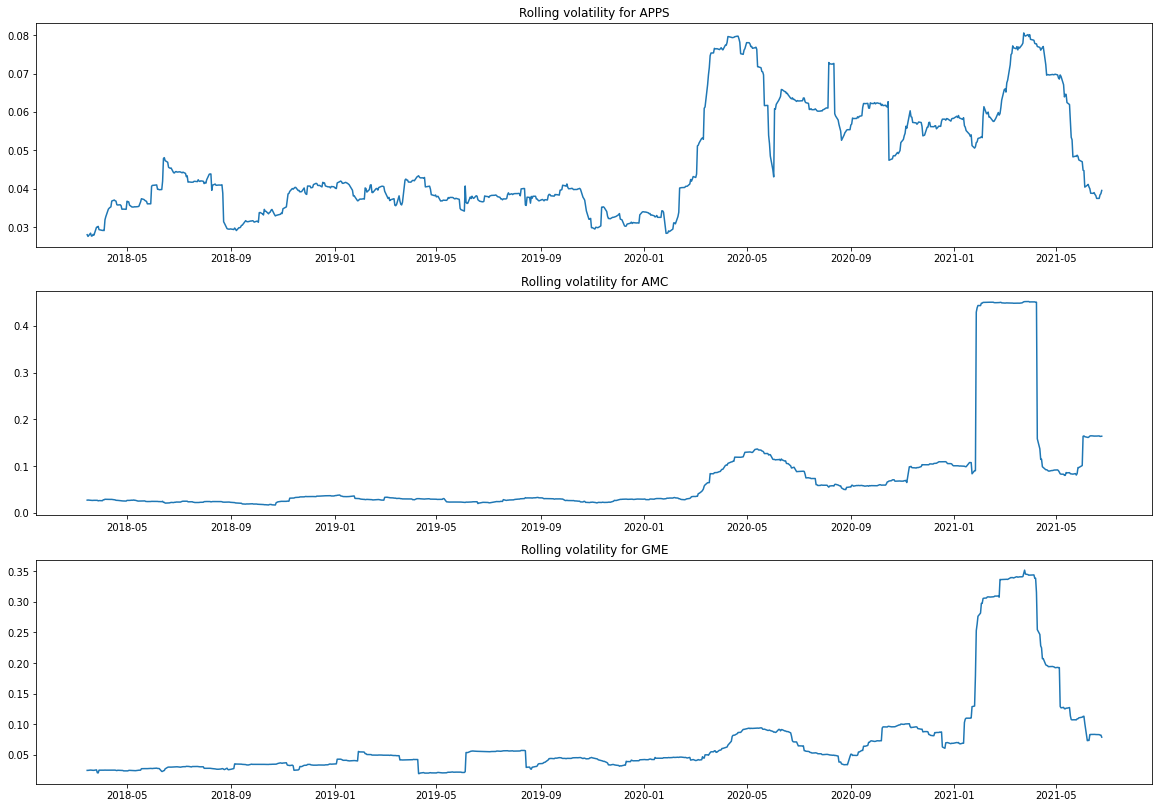

In [ ]:
# Calculate rolling volatility for each asset in a list and plot it: 
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_size_inches(20, 14)
ax1.plot(rolling_volatility(df_filter_returns['APPS'], 50))
ax1.set_title("Rolling volatility for APPS")


ax2.plot(rolling_volatility(df_filter_returns['AMC'], 50))
ax2.set_title("Rolling volatility for AMC")

ax3.plot(rolling_volatility(df_filter_returns['GME'], 50))
ax3.set_title("Rolling volatility for GME")


## Test historical and analytica VaR & ES 

In [ ]:

# Test VaR calculation:

apps_ret = df_filter_returns['APPS']
# Historical VaR and ES for APPS:
apps_historical_VaR = historical_var(apps_ret, 5)
apps_historical_ES = historical_expected_shortfall(apps_ret, 5)
# Analytical VaR and ES for APPS:
apps_analytical_VaR = analytical_distribution_VaR(apps_ret.mean(), 5, apps_ret.std(), 'normal', 6)
apps_analytical_ES =analytical_distribution_ES(apps_ret.mean(), 5, apps_ret.std(), 'normal', 6)

amc_ret = df_filter_returns['AMC']
# Historical VaR and ES for APPS:
amc_historical_VaR = historical_var(amc_ret, 5)
amc_historical_ES = historical_expected_shortfall(amc_ret, 5)
# Analytical VaR and ES for APPS:
amc_analytical_VaR = analytical_distribution_VaR(amc_ret.mean(), 5, amc_ret.std(), 'normal', 6)
amc_analytical_ES =analytical_distribution_ES(amc_ret.mean(), 5, amc_ret.std(), 'normal', 6)


gme_ret = df_filter_returns['GME']
# Historical VaR and ES for APPS:
gme_historical_VaR = historical_var(gme_ret, 5)
gme_historical_ES = historical_expected_shortfall(gme_ret, 5)
# Analytical VaR and ES for APPS:
gme_analytical_VaR = analytical_distribution_VaR(gme_ret.mean(), 5, amc_ret.std(), 'normal', 6)
gme_analytical_ES =analytical_distribution_ES(gme_ret.mean(), 5, amc_ret.std(), 'normal', 6)


print('#'*15 + ' RESULTS ' + '#'*15)
print('Results for APPS:')
print('Historical VaR: ' + str(apps_historical_VaR))
print('Analytical VaR: ' + str(apps_analytical_VaR))
print('Historical ES: ' + str(apps_historical_ES))
print('Analytical ES: ' + str(apps_analytical_ES))
print('#'*39)
print('Results for AMC:')
print('Historical VaR: ' + str(amc_historical_VaR))
print('Analytical VaR: ' + str(amc_analytical_VaR))
print('Historical ES: ' + str(amc_historical_ES))
print('Analytical ES: ' + str(amc_analytical_ES))
print('#'*39)
print('Results for GME:')
print('Historical VaR: ' + str(gme_historical_VaR))
print('Analytical VaR: ' + str(gme_analytical_VaR))
print('Historical ES: ' + str(gme_historical_ES))
print('Analytical ES: ' + str(gme_analytical_ES))





############### RESULTS ###############
Results for APPS:
Historical VaR: 0.06837444230853491
Analytical VaR: 0.07529950797011523
Historical ES: 0.0956244023427819
Analytical ES: 0.0958336599100009
#######################################
Results for AMC:
Historical VaR: 0.08274901430624619
Analytical VaR: 0.20425570045416186
Historical ES: 0.14866663605081568
Analytical ES: 0.2577756439239769
#######################################
Results for GME:
Historical VaR: 0.07671998214707809
Analytical VaR: 0.20333713587170543
Historical ES: 0.16101228097436923
Analytical ES: 0.2568570793415205


## Testing Monte Carlo VaR:

In [ ]:
mc_VaR, mc_ES = monte_carlo_VaR_ES(df_filter_returns, [0.33, 0.33, 0.33], 5, 100, 1000, 10000)
print("Portoflio's Value-at-Risk: "  + str(mc_VaR))
print("Portfolio's Expected Shortfall: "  + str(mc_ES))

Portoflio's Value-at-Risk: 0.9434293785939326
Portfolio's Expected Shortfall: 1.1069708880725608


## SMTH ELSE

In [ ]:
# Download data: 

# Define parameters of the download: 

symbol = ['APPS', 'AMC', 'GME']
start_date = '2018-01-01'
end_date = '2021-06-25'

df = stock_data_download(symbol, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


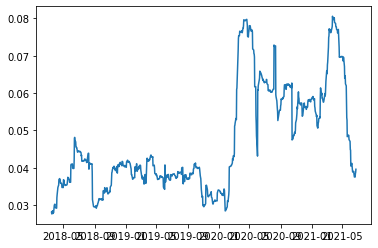

In [ ]:
dd = df['APPS']['Adj Close'].pct_change()
rv=rolling_volatility(dd, 50)
plt.plot(rv)

In [ ]:
am = arch_model(apps_ret, vol="Garch", p=1, o=0, q=1, dist="Normal")
res = am.fit(disp="off", last_obs="2018-12-31")

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0014. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [ ]:
forecasts = res.forecast(start="2019-1-1", reindex=False)
cond_mean = forecasts.mean["2019":]
cond_var = forecasts.variance["2019":]
q = am.distribution.ppf([0.01, 0.05]) #res.params[-2:])
print(q)

[-2.32634787 -1.64485363]


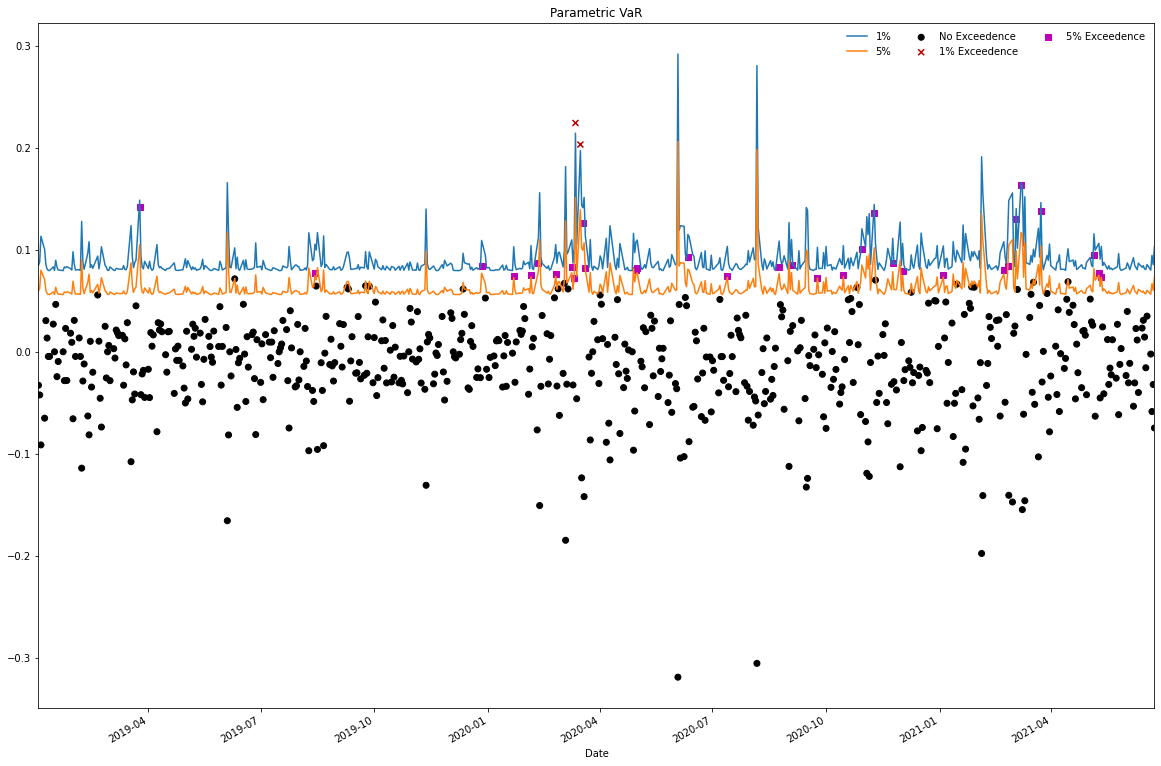

In [ ]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=["1%", "5%"], index=cond_var.index)
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = apps_ret["2019":].copy()
rets_2018.name = "APPS Return"
c = []
for idx in value_at_risk.index:
    if rets_2018[idx] > -value_at_risk.loc[idx, "5%"]:
        c.append("#000000")
    elif rets_2018[idx] < -value_at_risk.loc[idx, "1%"]:
        c.append("#BB0000")
    else:
        c.append("#BB00BB")
c = np.array(c, dtype="object")
labels = {
    "#BB0000": "1% Exceedence",
    "#BB00BB": "5% Exceedence",
    "#000000": "No Exceedence",
}
markers = {"#BB0000": "x", "#BB00BB": "s", "#000000": "o"}
for color in np.unique(c):
    sel = c == color
    ax.scatter(
      rets_2018.index[sel],
      -rets_2018.loc[sel],
      marker=markers[color],
      c=c[sel],
      label=labels[color],
    )

ax.set_title("Parametric VaR")
leg = ax.legend(frameon=False, ncol=3)
plt.rcParams['figure.figsize'] = [2, 2]
